In [36]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rng

# Module 2: Gradient Descent

Brute-force search does not scale beyond a few free parameters, can we do better?

## Null Model

Let's first look at how the loss function changes as $c$ changes. We can adapt the brute-force search algorithm from Module 1 to visualize the loss function over values of $c$.

In [37]:
# read data
data = np.load('code/day2/fake_data.npz')
# assign X and y numpy arrays
X, y = data['X'], data['y']

Text(0, 0.5, 'MSE')

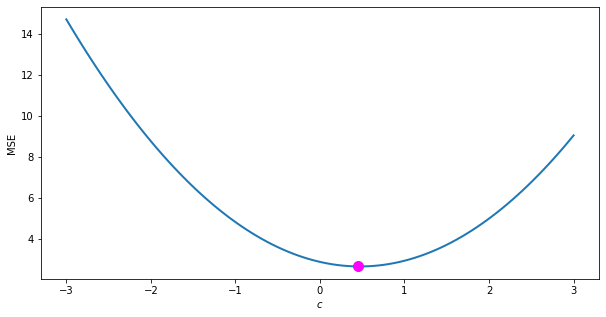

In [38]:
# initialize the search "grid": 100 evenly-spaced points from -3 to 3
cs = np.linspace(-3, 3, 100)

# initialize an empty array to hold mse value for each candidate c
mses = []

# for each candidate c
for c in cs:
    
    # predict the value at the given x values (just a constant)
    yhat = np.ones_like(X) * c
    
    # compute mse
    mse = np.mean( np.square(yhat - y) )
    
    # add to results
    mses.append(mse)

# argmin returns the index of the element with the lowest value
best_ix = np.argmin(mses)

# using that index we can get the best c value
best_c = cs[best_ix]

# now visualize the landscape
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(cs, mses, linewidth=2)
ax.plot([best_c], mses[best_ix], marker='o', color='magenta', markersize=10)
ax.set_xlabel('$c$')
ax.set_ylabel('MSE')

Imagine dropping a ball at some random value of $c$, where would the ball go?

- If the curve is flat, the ball stays
- If the curve is pointing up, the ball rolls backwards
- If the curve is pointing down, the ball rolls forwards

**Idea**: Simulate the behavior of the ball. The ball stops moving when it is at a minimum. The location of the ball when it stops corresponds to the best value of $c$.

- To do this, we need to know the _steepness_ of the curve at value of $c$.
- The _steepness_ corresponds to the slope, which is just the first derivative of the loss function

$$\frac{d}{dc}\mathcal{L}(\mathbf{y},\hat{\mathbf{y}})=\frac{1}{N}\sum_{i}\frac{d}{dc}\left(y_{i}-\hat{y}_{i}\right)^{2}$$

$$\frac{d}{dc}\left(y_{i}-\hat{y}_{i}\right)^{2}=2(\hat{y}_{i}-y_{i})$$

* The slope at a given point $i$ is positive if the model over-predicts
* The slope at a given point $i$ is negative if the model under-predicts

**We call the derivative of the loss function the Gradient**. Let's plot the gradient of the loss function of the null model.


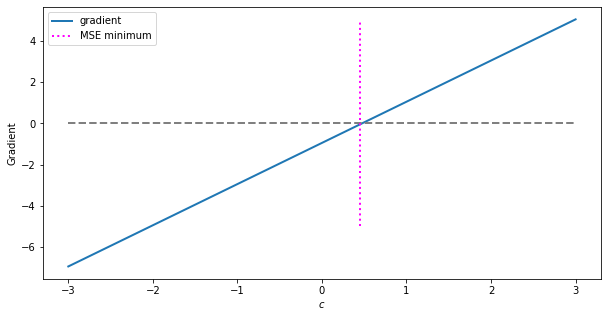

In [39]:
grads = []
for c in cs:
    
    # first compute the prediction yhat = c
    yhat = np.ones_like(X) * c 
    
    # now compute the gradient
    grad = np.mean( 2 * (yhat - y) )
    grads.append(grad)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(cs, grads, linewidth=2, label='gradient')
ax.plot(cs, np.zeros_like(cs), linewidth=2, color='grey', linestyle='dashed')
ax.plot([best_c, best_c], [-5, 5], linewidth=2, color='magenta', linestyle='dotted', label='MSE minimum')
ax.set_xlabel('$c$')
ax.set_ylabel('Gradient')
ax.legend()

* The grey line is the zero-gradient line and the magenta line is the location of the minimum. 
* The minimum occurs when the gradient is zero.

<font color='magenta'>**Idea for an algorithm**:</font>

If the gradient is negative, increase $c$. And if it is positive, decrease $c$.

**<font color='red'>Why Not Just Use Calculus?</font>**

* In this case, we can analytically find the minimum of the loss function without any optimization
* But in most interesting models, the analytical solution is difficult or non-existent

### Gradient Descent

Gradient descent is an algorithm for finding a <font color='red'>**local**</font> minimum of a function numerically. 

1. Initialize $c$ to a random value
2. Repeat until convergence:
    1. Compute model predictions $\hat{y}$
    2. Compute the gradient at those predictions $\frac{d}{dc}\mathcal{L}(\mathbf{y},\hat{\mathbf{y}})$
    3. Update $c$ by moving in the <font color='red'>opposite</font> direction of the gradient:
    
$$c:=c-\eta\frac{d}{dc}\mathcal{L}(\mathbf{y},\hat{\mathbf{y}})$$

Here $\eta$ is the learning rate. It controls the size of the steps that the algorithm makes. It is a very important parameter that affects the speed and quality of optimization, as we'll see now.


Best c: 1.21, mse: 3.2235


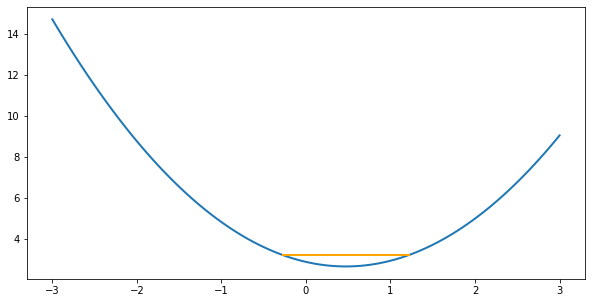

In [40]:

# generate random normal variable with mean 0 and std 1
c = rng.randn()
#c = 2

# number of iterations
N = 15

# learning rate
# try 0.1, 0.9, and 1
eta = 1

# array to hold steps that the algorithm made so that
# we can visualize them later
steps = []
steps_mse = []
for i in range(N):
    
    # compute model predictions
    yhat = np.ones_like(X) * c 
    
    # compute gradient at those predictions
    grad = np.mean( 2 * (yhat - y) )
    
    # update
    c = c - eta * grad
    
    steps.append(c)
    
    # compute mse at this new c (need to recompute yhat)
    yhat = np.ones_like(X) * c
    steps_mse.append(np.mean(np.square(yhat - y)))
    
print("Best c: %0.2f, mse: %0.4f" % (c, steps_mse[-1]))

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(cs, mses, linewidth=2)
ax.plot(steps, steps_mse, linewidth=2, color='orange')

* For a small learning rate, the model is too careful; it takes too long to train
* For a large learning rate, the model overshoots the local minima and potentially never converges
* There is no universal optimal learning rate, it depends on the model, data, and loss function
* There are schemes that adapt the learning rate: start with a large rate then reduce as learning progresses
* For now, we'll just use a fixed learning rate.

## Linear Model

* Let's take a look at the loss landscape of the linear model from Module 1. Remember, the model has two parameters, $\beta_0$ and $\beta_1$, so the loss landscape is three dimensional.
* Again, we can adapt the brute-force search code from Module 1 to visualize the loss landscape. But we'll introduce a change that will make it easier to visualize the loss surface.
* This change requires numpy's `meshgrid` function. Meshgrid accepts multiple arrays and returns all possible combinations of their elements.

In [41]:
a = [1, 2, 3]
b = [4, 5, 6]
C1, C2 = np.meshgrid(a, b)

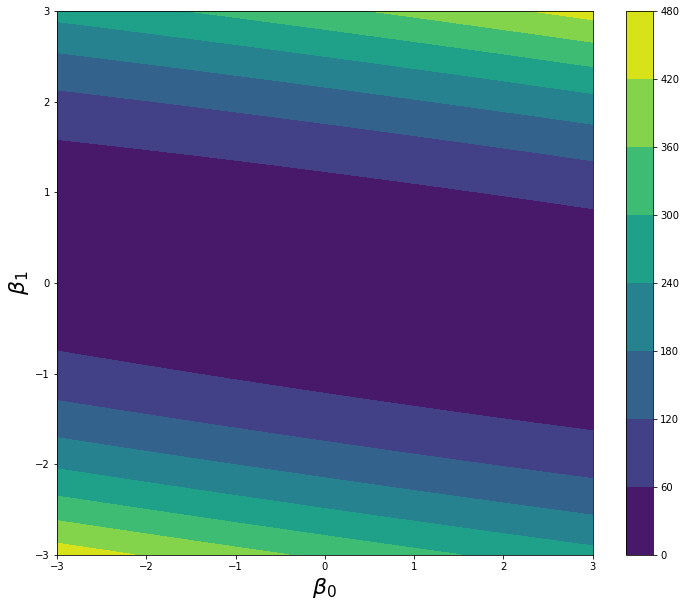

In [42]:
# initialize the search grid
beta_0s = np.linspace(-3, 3, 100)
beta_1s = np.linspace(-3, 3, 100)

# initialize parameter combinations
B0, B1 = np.meshgrid(beta_0s, beta_1s)

# initialize space to store MSE for each combination
mses = np.zeros_like(B0)

# for each candidate
for i in range(mses.shape[0]):
    for j in range(mses.shape[1]):
        b0, b1 = B0[i, j], B1[i, j]
        
        # predict the value 
        yhat = b0 + b1 * X
        
        mses[i, j] = np.mean(np.square(yhat-y))

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
cp = ax.contourf(B0, B1, mses)
ax.set_xlabel(r'$\beta_0$', fontsize=22)
ax.set_ylabel(r'$\beta_1$', fontsize=22)
cbar = fig.colorbar(cp, ax=ax)

### Linear Model Gradients

* Unlike the null model, the linear model has two free parameters
* So we need to take the _partial_ derivative of the loss with respect to the parameters

$$\hat{y}_{i}=\beta_{0}+\beta_{1}x_{i}$$
$$\frac{\partial}{\partial\beta_{0}}\left(y_{i}-\hat{y}_{i}\right)^{2}=2(\hat{y}_{i}-y_{i})$$
$$\frac{\partial}{\partial\beta_{1}}(y_{i}-\hat{y}_{i})^{2}=2(\hat{y}_{i}-y_{i})x_{i}$$

Armed with the gradients, we can implement gradient descent for the linear model.

Best mse: 2.25


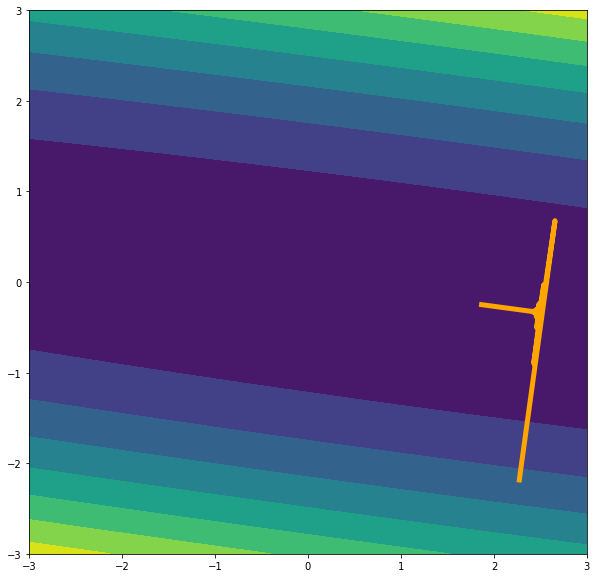

In [43]:
# generate two random normal variable with mean 0 and std 1
beta0, beta1 = rng.randn(2)
beta0, beta1 = [3, 3]

# number of iterations
N = 100

# learning rate
# try 0.001, 0.01, 0.02, 0.0257
eta = 0.02

# array to hold steps that the algorithm made so that
# we can visualize them later
steps = []
steps_mse = []
for i in range(N):
    
    # compute model predictions
    yhat = X * beta1 + beta0
    
    # compute gradient at those predictions
    beta0_grad = np.mean(2 * (yhat - y))
    beta1_grad = np.mean(2 * (yhat - y) * X)
    
    # update
    beta0 = beta0 - eta * beta0_grad
    beta1 = beta1 - eta * beta1_grad
    
    # track progress
    steps.append([beta0, beta1])
    yhat = X * beta1 + beta0
    steps_mse.append(np.mean(np.square(yhat - y)))

steps = np.array(steps)
print("Best mse: %0.2f" % steps_mse[-1])

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
cp = ax.contourf(B0, B1, mses)
ax.plot(steps[:,0], steps[:,1], color='orange', linewidth=5)

## Nonlinear Model

* We will cap this module by implementing gradient descent for the nonlinear model. 
* But first, let's look at the loss surface for the nonlinear model.

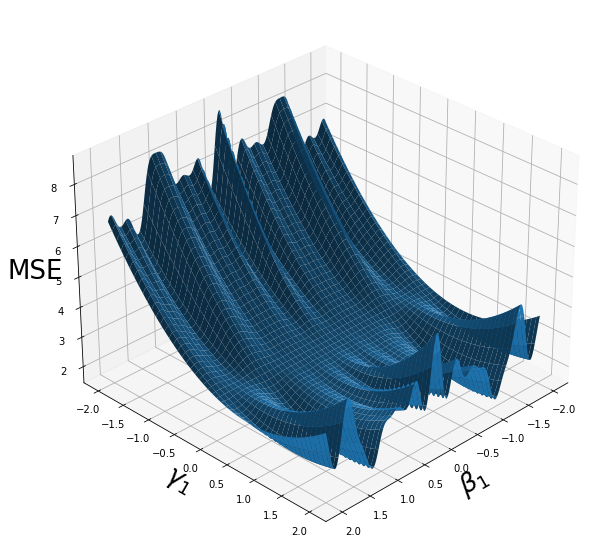

In [44]:
from mpl_toolkits.mplot3d import Axes3D

beta1s = np.linspace(-2, 2, 200)
gamma1s = np.linspace(-2, 2, 200)

B1, G1 = np.meshgrid(beta1s, gamma1s)
Z = np.zeros_like(B1)
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        beta1 = B1[i,j]
        gamma1 = G1[i,j]
        yhat = gamma1 * np.cos(beta1 * X)
        Z[i,j] = np.mean(np.square(yhat - y))

f = plt.figure(figsize=(10, 10))
ax1 = f.add_subplot(1, 1, 1, projection='3d')
ax1.plot_surface(B1, G1, Z)
ax1.set_xlabel(r'$\beta_1$', fontsize=26)
ax1.set_ylabel(r'$\gamma_1$', fontsize=26)
ax1.set_zlabel(r'MSE', fontsize=26)
ax1.view_init(30, 45)


Contour plot:

Text(0, 0.5, '$\\gamma_1$')

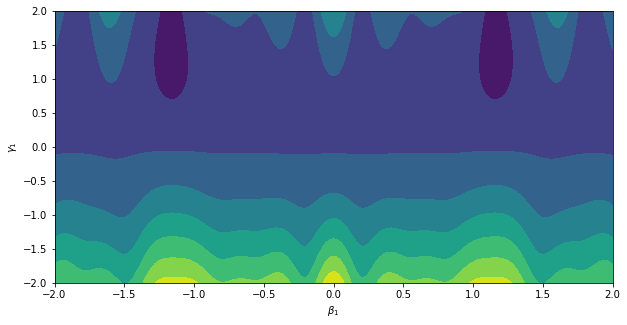

In [45]:
f, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.contourf(B1, G1, Z)
ax.set_xlabel(r'$\beta_1$')
ax.set_ylabel(r'$\gamma_1$')

* This loss surface is complicated with many local minima
* For gradient descent, solution depends on where you start from (initialization)

### Nonlinear Model Gradients


Recall the nonlinear model equations:

$$g(x) = cos(\beta_0 + \beta_1x) \\
\hat{y} = \gamma_0 + \gamma_1g(x)$$

To compute the gradients for this model, we will apply the <font color="red">Chain Rule</font> from calculus:

$$\frac{dz}{dx}=\frac{dz}{dy}\frac{dy}{dx}$$

First, let's compute the easy gradients: those with respect to parameters nearest to the output, $\gamma_0$ and $\gamma_1$:

$$\frac{\partial}{\partial\gamma_{0}}(y_{i}-\hat{y}_{i})^{2}=2(\hat{y}_{i}-y_{i})$$
$$\frac{\partial}{\partial\gamma_{1}}(y_{i}-\hat{y}_{i})^{2}=2(\hat{y}_{i}-y_{i})g(x)$$

* Notice something? if you pretend that $g(x)$ is $x$, the previous equations are identical to the linear model's equations! 
* This modularity pays dividends as it allows us to compute the gradients of arbitarily complicated functions

Next, are the gradients furthest from the output. To compute these, we'll pretend that $g(x)$ is the output:

$$\frac{\partial g(x)}{\partial\beta_{0}}=-sin(\beta_{0}+\beta_{1}x)$$
$$\frac{\partial g(x)}{\partial\beta_{1}}=-xsin(\beta_{0}+\beta_{1}x)$$

Now, we can compute the gradient of the loss with respect to $\beta_0$ and $\beta_1$ by applying the chain rule:

$$\frac{\partial}{\partial\beta_{0}}(y_{i}-\hat{y}_{i})^{2}=\frac{\partial}{\partial g}(y_{i}-\hat{y}_{i})^{2}\frac{\partial g}{\partial\beta_{0}}=-2\gamma_{1}(\hat{y}_{i}-y_{i})sin(\beta_{0}+\beta_{1}x)$$

$$\frac{\partial}{\partial\beta_{1}}(y_{i}-\hat{y}_{i})^{2}=-2x\gamma_{1}(\hat{y}_{i}-y_{i})sin(\beta_{0}+\beta_{1}x)$$

Notice how gradient computation decomposes nicely: first we compute $\frac{\partial}{\partial g}(y_{i}-\hat{y}_{i})^{2}$ followed by $\frac{\partial g}{\partial\beta_{0}}$ and $\frac{\partial g}{\partial\beta_{1}}$.

We can now go ahead and implement gradient descent algorithm for the nonlinear model. Try running a few times to see how the best solution changes.

In [46]:
# initialize parameter values
model_params = rng.randn(4)
model_params = [0.2, 0.2, 0.2, 0.2]
# number of iterations
N = 500

# learning rate
eta = 0.1

# array to hold steps that the algorithm made so that
# we can visualize them later
steps = []
steps_mse = []
for i in range(N):
    beta0, beta1, gamma0, gamma1 = model_params 
    
    # compute model predictions
    g = np.cos(beta0 + beta1 * X)
    yhat = gamma0 + gamma1 * g
    
    # compute gradient at those predictions
    beta0_grad = np.mean(-2 * gamma1 * (yhat - y) * np.sin(beta0 + beta1 * X))
    beta1_grad = np.mean(-2 * gamma1 * X * (yhat - y) * np.sin(beta0 + beta1 * X))
    gamma0_grad = np.mean(2 * (yhat - y))
    gamma1_grad = np.mean(2 * (yhat - y) * g)
    
    # update
    grads = np.array([beta0_grad, beta1_grad, gamma0_grad, gamma1_grad])
    model_params = model_params - eta * grads
    
    # track progress
    steps.append(model_params)
    beta0, beta1, gamma0, gamma1 = model_params 
    
    g = np.cos(beta0 + beta1 * X)
    yhat = gamma0 + gamma1 * g
    steps_mse.append(np.mean(np.square(yhat - y)))

print("Best MSE: %0.4f" % steps_mse[-1])

Best MSE: 1.7543


### Refactoring

Let's clean up the code a bit to take advantage of the modularity that the chain rule of calculus provides. We will define to Python classes `LinearUnit` and `CosineUnit` which know how to compute $\gamma_0 + \gamma_1x$ and $cos(\beta_0 + \beta_1x)$ and their gradients, respectively.

* Each class knows how to compute the output (known as forward pass), the gradient of the output with respect to the input, and the gradient of the output with respect to the weights.

* With this local information alone, we can compose arbitarily complex mathematical functions and compute their gradients easily.


In [53]:
class LinearUnit:
    """ Linear Unit, assumes that input has one feature (dimension 1) """
    
    def __init__(self):
        self.gammas = rng.randn(2)

    def forward(self, x):
        self.y = self.gammas[0] + self.gammas[1] * x 
        return self.y 
    
    def grad_wrt_input(self, x):
        self.grad_x = np.ones_like(x) * self.gammas[1]
        return self.grad_x
    
    def grad_wrt_weights(self, x):
        return [
            np.ones_like(x),
            x
        ]
        
    def update_weights(self, g):
        self.gammas = self.gammas - g

class CosineUnit:
    
    def __init__(self):
        self.betas = rng.randn(2)
        
    def forward(self, x):
        self.y = np.cos(self.betas[0] + self.betas[1] * x)
        return self.y 
    
    def grad_wrt_input(self, x):
        return -self.betas[1] * np.sin(self.betas[0] + self.betas[1] * x)
    
    def grad_wrt_weights(self, x):
        return [
            -np.sin(self.betas[0] + self.betas[1] * x),
            -x * np.sin(self.betas[0] + self.betas[1] * x)
        ]
    
    def update_weights(self, g):
        self.betas = self.betas - g
        
class MeanSquaredErrorLoss:
    
    def __init__(self):
        pass 
    
    def compute(self, yhat, y):
        return np.mean(np.square(yhat - y))
    
    def grad_wrt_yhat(self, yhat, y):
        return 2 * (yhat - y)


# initialize model
cs = CosineUnit()
lu = LinearUnit()
loss = MeanSquaredErrorLoss()

# number of iterations
N = 500

# learning rate
# try 0.001, 0.01, 0.02, 0.0257
eta = 0.1

# array to hold steps that the algorithm made so that
# we can visualize them later
steps_mse = []
for i in range(N):
    
    # compute model predictions (forward pass)
    cs_output = cs.forward(X)
    yhat = lu.forward(cs_output)
    
    # compute gradients (backward pass)
    grads = loss.grad_wrt_yhat(yhat, y)
    dyhat_dweights = lu.grad_wrt_weights(cs_output)
    for i in range(len(dyhat_dweights)):
        dyhat_dweights[i] = eta * np.mean(grads * dyhat_dweights[i])
    
    grads = grads * lu.grad_wrt_input(cs_output)
    dcs_dweights = cs.grad_wrt_weights(X)
    for i in range(len(dcs_dweights)):
        dcs_dweights[i] = eta * np.mean(grads * dcs_dweights[i])
    
    # update weights
    lu.update_weights(dyhat_dweights)
    cs.update_weights(dcs_dweights)
    
    # track progress
    yhat = lu.forward(cs.forward(X))
    steps_mse.append(np.mean(np.square(yhat - y)))

steps = np.array(steps)
print("Best mse: %0.2f" % steps_mse[-1])



Best mse: 1.70


## Recap

* What you have just implemented is a very simple neural network with one hidden neuron, the $cos()$ function, and one output neuron.

* The algorithm used to train the network is called "Backpropagation", and it is simply gradient descent.

* Backpropagation consists of a forward pass and a backward pass:

    * **Forward Pass** is easy: just apply the mathematical function defined by the network on the inputs, while keeping track of all intermediate results.
    
    * **Backward Pass** requires the gradients. Here, intermediate results from the forward pass are used to compute the gradients.
    
* Backpropagation is very modular in nature. Units only need to know how to compute local information: the output, the gradient with respect to the inputs and weights. 